In [1]:
# # 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# !mkdir /home/aistudio/external-libraries
# # 安装pandas到指定目录
# !pip install pandas -t /home/aistudio/external-libraries

# # 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# import sys 
# sys.path.append('/home/aistudio/external-libraries')

# 一、数据处理

In [1]:
import paddle
import os
import cv2
from cv2 import IMREAD_GRAYSCALE
import numpy as np
class MyDataset(paddle.io.Dataset):
    def __init__(self, data_dir, label_path, transform=None):
        super(MyDataset, self).__init__()
        self.datalist = []
        with open(label_path, encoding='utf-8') as f:
            for line in f.readlines():
                line = line.strip().split("\t")
                image_path, label = line[0], line[1]
                image_path = os.path.join(data_dir, image_path)
                self.datalist.append([image_path, label])
        self.transform = transform
    
    def __getitem__(self, index):
        image_path, label = self.datalist[index]
        image = cv2.imread(image_path, flags=IMREAD_GRAYSCALE)
        image = image.astype("float32")
        if self.transform is not None:
            image = self.transform(image)
            image = image[0]
        label = np.array([label], dtype='int64')
        return image, label

    def __len__(self):
        return len(self.datalist)
    

In [2]:
transform = paddle.vision.transforms.Normalize(mean=127.5, std=127.5, data_format="CHW")
mnist_path = './data/data179656/mnist'
train_dataset = MyDataset(os.path.join(mnist_path, 'train'), os.path.join(mnist_path, 'train/label.txt'), transform)
test_dataset = MyDataset(os.path.join(mnist_path, 'val'), os.path.join(mnist_path, 'val/label.txt'), transform)
print('train_dataset_images:', len(train_dataset))
print("test_dataset_images:", len(test_dataset))


train_dataset_images: 60000
test_dataset_images: 10000


batch id: 0, 训练数据shape: [64, 28, 28], 训练标签shape: [64, 1]
label: 8


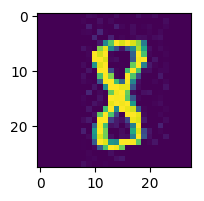

In [4]:
import matplotlib.pyplot as plt
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
for batch_id, (images, labels) in enumerate(train_loader):
    print(f"batch id: {batch_id}, 训练数据shape: {images.shape}, 训练标签shape: {labels.shape}")
    plt.figure(figsize=(2,2))
    i = 60
    plt.imshow(images[i])
    print("label:", labels[i].item())
    break


# 二、模型设计

In [5]:
class MyDNN(paddle.nn.Layer):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.linear1 = paddle.nn.Linear(in_features=1*28*28, out_features=50)
        self.relu1 = paddle.nn.ReLU()
        self.linear2 = paddle.nn.Linear(in_features=50, out_features=50)
        self.relu2 = paddle.nn.ReLU()
        self.linear3 = paddle.nn.Linear(in_features=50, out_features=10)
        self.softmax = paddle.nn.Softmax()
    
    def forward(self, input):
        x = paddle.reshape(input, shape=[-1,1*28*28])
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        return self.softmax(self.linear3(x))


# 三、模型训练

In [13]:
myDNN = MyDNN()
epoch = 10
optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=myDNN.parameters())
loss_func = paddle.nn.CrossEntropyLoss()
myDNN.train()
for epoch_id in range(epoch):
    for batch_id, (images, labels) in enumerate(train_loader):
        predicts = myDNN(images)
        loss = loss_func(predicts, labels)
        acc = paddle.metric.accuracy(predicts, labels)
        loss.backward()
        if (batch_id + 1) % 100 == 0:
            print(f"epoch:{epoch_id + 1}/{epoch}, batch_id:{batch_id + 1}, loss:{loss.numpy()}\t, accuracy:{acc.numpy()}")
        optimizer.step()
        optimizer.clear_grad()


epoch:1/10, batch_id:100, loss:[1.7954395]	, accuracy:[0.703125]
epoch:1/10, batch_id:200, loss:[1.8531218]	, accuracy:[0.625]
epoch:1/10, batch_id:300, loss:[1.8548498]	, accuracy:[0.625]
epoch:1/10, batch_id:400, loss:[1.8659321]	, accuracy:[0.578125]
epoch:1/10, batch_id:500, loss:[1.7113037]	, accuracy:[0.765625]
epoch:1/10, batch_id:600, loss:[1.6960232]	, accuracy:[0.78125]
epoch:1/10, batch_id:700, loss:[1.7194028]	, accuracy:[0.75]
epoch:1/10, batch_id:800, loss:[1.6733601]	, accuracy:[0.8125]
epoch:1/10, batch_id:900, loss:[1.806128]	, accuracy:[0.671875]
epoch:2/10, batch_id:100, loss:[1.701364]	, accuracy:[0.765625]
epoch:2/10, batch_id:200, loss:[1.6469016]	, accuracy:[0.828125]
epoch:2/10, batch_id:300, loss:[1.6500835]	, accuracy:[0.8125]
epoch:2/10, batch_id:400, loss:[1.7875024]	, accuracy:[0.6875]
epoch:2/10, batch_id:500, loss:[1.6856301]	, accuracy:[0.78125]
epoch:2/10, batch_id:600, loss:[1.6629733]	, accuracy:[0.796875]
epoch:2/10, batch_id:700, loss:[1.6195068]	, 

# 四、模型评估与推理

batch_id:30, loss:[1.5418118]	, accuracy:[0.90625]
batch_id:60, loss:[1.5687321]	, accuracy:[0.890625]
batch_id:90, loss:[1.5086946]	, accuracy:[0.953125]
batch_id:120, loss:[1.4722354]	, accuracy:[0.984375]
batch_id:150, loss:[1.5177898]	, accuracy:[0.953125]
true:7, predict:7


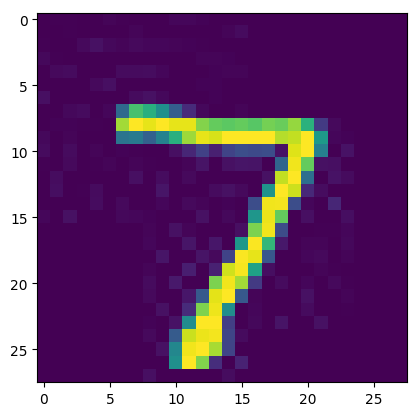

In [14]:
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
myDNN.eval()
for batch_id, (images, labels) in enumerate(test_loader):
    predicts = myDNN(images)
    loss = loss_func(predicts, labels)
    acc = paddle.metric.accuracy(predicts, labels)
    if (batch_id + 1) % 30 == 0:
        print(f"batch_id:{batch_id + 1}, loss:{loss.numpy()}\t, accuracy:{acc.numpy()}")
images_, labels_ = test_loader().next()
i = 0
predict_label = myDNN(images_)[i].argmax()
print(f"true:{labels_[i].item()}, predict:{predict_label[i].item()}")
plt.imshow(images_[i])

In [15]:
paddle.save(myDNN.state_dict(), "LinearNet_LayerParams.pdparams")
paddle.save(optimizer.state_dict(), "Optimizer_AdamParams.adopt")

In [16]:
layer_dict = paddle.load("LinearNet_LayerParams.pdparams")
opti_dict = paddle.load("Optimizer_AdamParams.adopt")

myNet = MyDNN()
myNet.set_state_dict(layer_dict)
optimizer2 = paddle.optimizer.Adam(learning_rate=0.001, parameters=myNet.parameters())
optimizer2.set_state_dict(opti_dict)

batch_id:30, loss:[1.5418118]	, accuracy:[0.90625]
batch_id:60, loss:[1.5687321]	, accuracy:[0.890625]
batch_id:90, loss:[1.5086946]	, accuracy:[0.953125]
batch_id:120, loss:[1.4722354]	, accuracy:[0.984375]
batch_id:150, loss:[1.5177898]	, accuracy:[0.953125]
true:3, predict:3


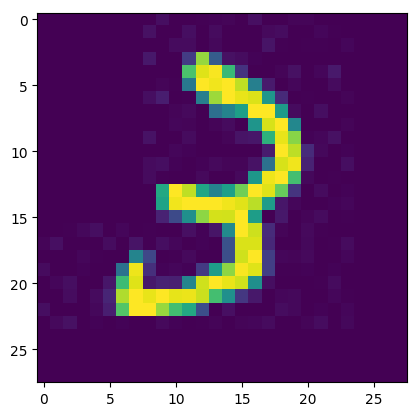

In [17]:
myNet.eval()
for batch_id, (images, labels) in enumerate(test_loader):
    predicts = myNet(images)
    loss = loss_func(predicts, labels)
    acc = paddle.metric.accuracy(predicts, labels)
    if (batch_id + 1) % 30 == 0:
        print(f"batch_id:{batch_id + 1}, loss:{loss.numpy()}\t, accuracy:{acc.numpy()}")
images_, labels_ = test_loader().next()
i = -1
predict_label = myDNN(images_)[i].argmax()
print(f"true:{labels_[i].item()}, predict:{predict_label[i].item()}")
plt.imshow(images_[i])